# Gridded Mooring Data - Quick Plot

From an erddap Dataset, specify the Mooring ID to get a quick plot of the data

In [41]:
from erddapy import ERDDAP
import xarray as xa
import numpy as np

In [97]:
server_url = 'http://ecofoci-field.pmel.noaa.gov:8080/erddap'
dataset_name = '1hr_gridded_datasets_Mooring_10csp1a_final'
e = ERDDAP(server=server_url,
          protocol='griddap',
          response='ncCF')

e.dataset_id=dataset_name

xdf = e.to_xarray()
xdf

/Users/bell/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'temperature' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'pressure' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'salinity' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py39/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'PAR' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/bell/miniconda3/envs/py39/lib/python3.9/site-pa

<xarray.Dataset>
Dimensions:                   (depth: 34, time: 2179)
Coordinates:
  * depth                     (depth) float64 28.0 36.0 44.0 ... 284.0 292.0
  * time                      (time) datetime64[ns] 2010-05-20T22:00:00 ... 2...
Data variables:
    latitude                  (depth, time) float64 ...
    longitude                 (depth, time) float64 ...
    temperature               (depth, time) float64 ...
    pressure                  (depth, time) float64 ...
    salinity                  (depth, time) float64 ...
    PAR                       (depth, time) float64 ...
    Chlorophyll_Fluorescence  (depth, time) float64 ...
    Oxygen_Saturation         (depth, time) float64 ...
    Oxygen_Concentration      (depth, time) float64 ...
    Serial_Number             (depth, time) float64 ...
Attributes: (12/18)
    cdm_data_type:                 Grid
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    geospatial_vertical_max:       292.0
    geospatial_vertical_min:       28.0
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     m
    ...                            ...
    sourceUrl:                     (local files)
    standard_name_vocabulary:      CF Standard Name Table v55
    summary:                       QC'd (final) mooring data from 10CSP1A.  T...
    time_coverage_end:             2010-08-19T16:00:00Z
    time_coverage_start:           2010-05-20T22:00:00Z
    title:                         Gridded Mooring Data from 10CSP1A - final

In [98]:
xdf.temperature.dropna(dim='depth',how='all').plot()

IndexError: index -1 is out of bounds for axis 0 with size 0

## Export to CSV - via pandas

In [94]:
variable = 'salinity'

for g, group in xdf[variable].dropna(dim='depth',how='all').groupby('depth'):
    group.to_dataframe().to_csv(f'{dataset_name}_{variable}.{g}m.csv')

ValueError: depth must not be empty

## Perform 35hr Lanzcos Filter and export data

A common filter to apply to the hourly data is a 35hr Lanzcos Lowpass filter

In [92]:
import ecofocipy.math.lanzcos as lanzcos #<- instrument specific
import matplotlib.pyplot as plt


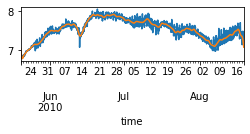

In [93]:
for g, group in xdf[variable].dropna(dim='depth',how='all').groupby('depth'):
    dft = group.to_dataframe().dropna()
    #
    ## missing data fill limited by number of hours to linearly interpolate
    temp = dft[variable].interpolate(method='time',limit=6)

    # get index of missing data that wasn't filled
    # the remaining missing data will continue to be missing after analysis
    # this data and the edges of the timeseries need to have the effects of the filter window accounted for

    missing_index = np.isnan(temp)
    temp = dft[variable].interpolate(method='time')

    #address gaps at beginning and end... back fill... and forward fill at end... 
    # the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
    temp.bfill(inplace=True)
    temp.ffill(inplace=True)

    #filter data with lanzcos filter
    lanzcosfiltered = lanzcos.lanzcos(temp.values,1,35) + dft[variable].mean()
    
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(4,1), sharex=True)
    temp.plot(ax=axes)
    (temp *0 + lanzcosfiltered).plot(ax=axes)
    
    (temp *0 + lanzcosfiltered).to_csv(f'{dataset_name}_{variable}_35hr.{g}m.csv')